<h4>Uploading image</h4>

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 
import numpy as np

(709, 1354, 3)

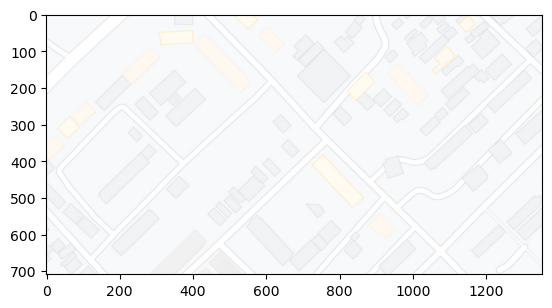

In [2]:
ex1 = mpimg.imread('C:/Users/Eldana/OneDrive - АО Казахстанско-Британский Технический Университет/Documents/Project/fvm/MeshGeneration/screens/ex1.png')
plt.imshow(ex1)
ex1.shape

<h4>Grayscale image</h4>

(709, 1354)

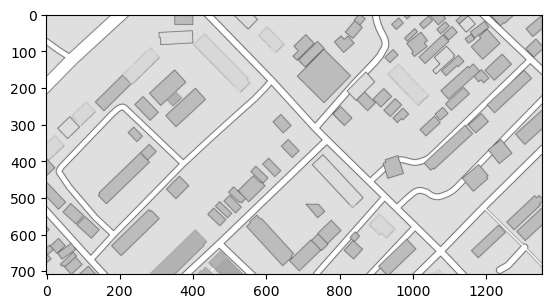

In [3]:
ex_gray = np.mean(ex1, axis = 2)
plt.imshow(ex_gray, cmap='gray')
ex_gray.shape

<h4> Separating road</h4>

In [5]:
road = np.copy(ex_gray)
for i in range(len(ex_gray)):
    for j in range(len(ex_gray[i])):
        if ex_gray[i][j] == 1.0:
            road[i][j] = 0.0
        else:
            road[i][j] = 1.0

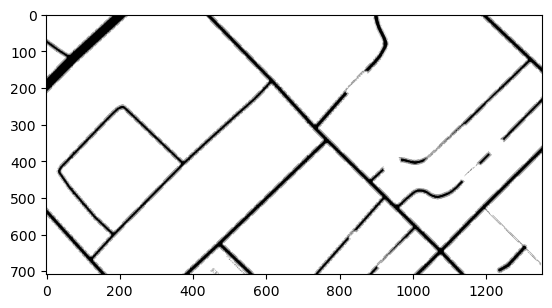

In [6]:
plt.imshow(road, cmap='gray')

<h4>Finding the intensity gradient of the image</h4>

In [4]:
def convolution_1channel(img, kernel):
    n, m, l = img.shape[0], img.shape[1], len(kernel)
    layer1 = list()
    for i in range(0, (n-l)+1, l):
        for j in range(0, (m-l)+1, l):
            layer1.append(np.sum(np.multiply(img[i:i+l, j:j+l], kernel)))
    layer1 = np.array(layer1).reshape((n//l), (m//l))
    return layer1

In [5]:
Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

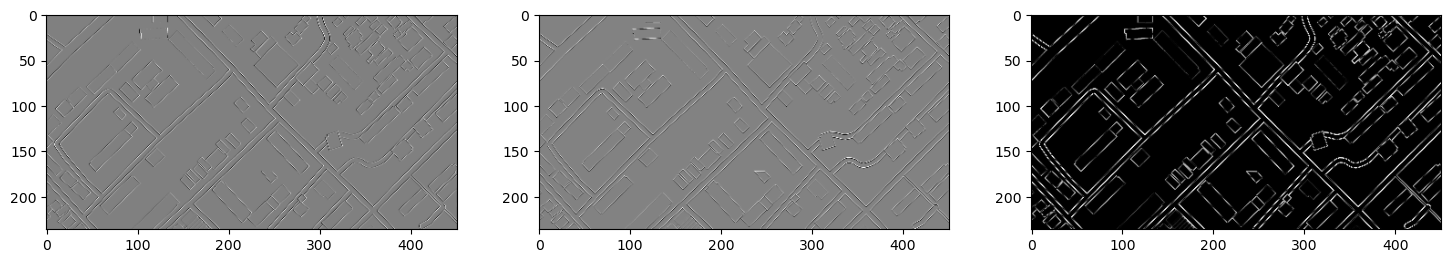

In [6]:
Gx = convolution_1channel(ex_gray, Kx)
Gy = convolution_1channel(ex_gray, Ky)
G = np.hypot(Gx, Gy)
G = G / G.max() * 255
theta = np.arctan2(Gy, Gx)
plt.figure(figsize=(18, 18))
plt.subplot(131)
plt.imshow(Gx, cmap='gray')
plt.subplot(132)
plt.imshow(Gy, cmap='gray')
plt.subplot(133)
plt.imshow(G.astype('int'), cmap='gray')

<h4>ReLU activator</h4>

In [29]:
def ReLU(img):
    n, m = img.shape[0], img.shape[1]
    for i in range(n):
        for j in range(m):
            img[i][j] = max(0, img[i][j])
            
    return img

In [30]:
ex_activated = ReLU(G)

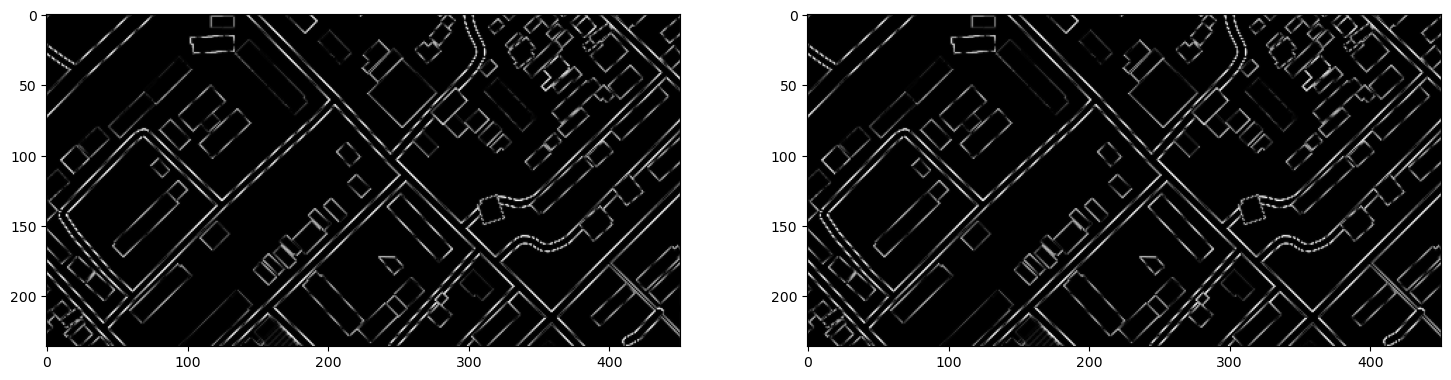

In [31]:
plt.figure(figsize=(18, 18))
plt.subplot(121)
plt.imshow(ex_activated.astype('int'), cmap='gray')
plt.subplot(122)
plt.imshow(G.astype('int'), cmap='gray')

<h4>Non Maximum Suppression</h4>

In [12]:
def non_max_suppression(img, theta):
    m, n = img.shape
    result = np.zeros((m,n))
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180
    for i in range(1,m-1):
        for j in range(1,n-1):
                q = 255
                r = 255
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]
                if (img[i,j] >= q) and (img[i,j] >= r):
                    result[i,j] = img[i,j]
                else:
                    result[i,j] = 0
    return result

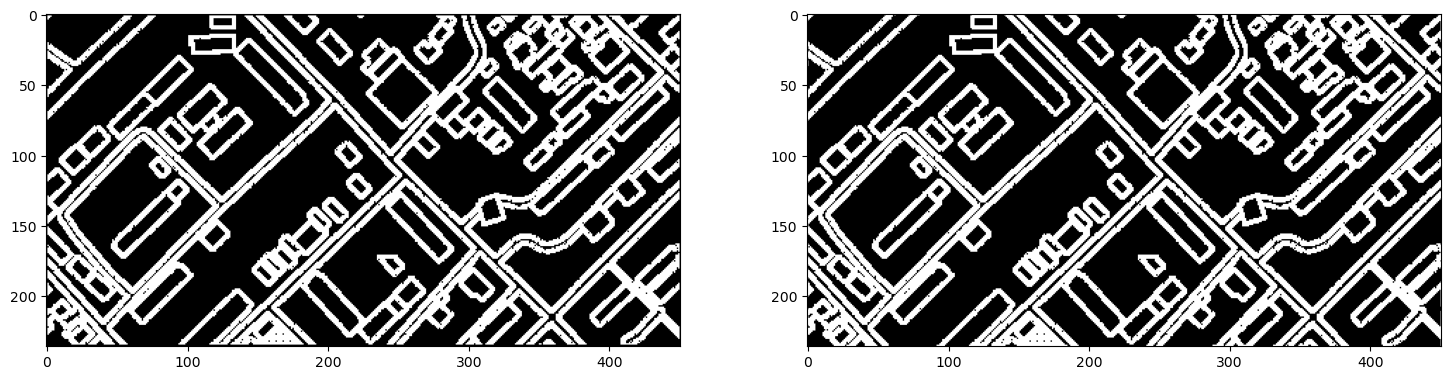

In [13]:
nms = non_max_suppression(G, theta)
plt.figure(figsize=(18, 18))
plt.subplot(121)
plt.imshow(nms.astype('int'), cmap='gray')
plt.subplot(122)
plt.imshow(G.astype('int'), cmap='gray')

<h4> Switching to binary type</h4>

In [7]:
def binary(img):
    n, m = img.shape[0], img.shape[1]
    for i in range(n):
        for j in range(m):
            if img[i][j]!=0:
                img[i][j] =255
    return img

In [10]:
ex_gray.min()

255.0

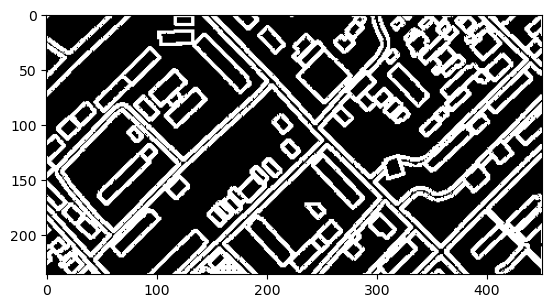

In [11]:
bina = binary(G)
plt.imshow(bina.astype('int'), cmap='gray')

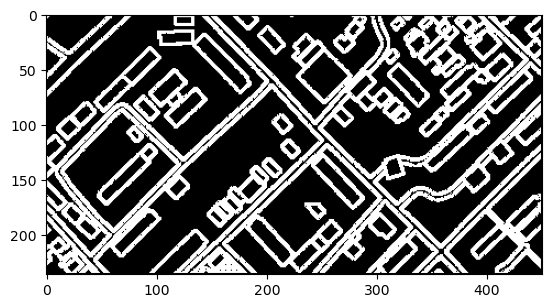

In [14]:
bina = binary(nms)
plt.imshow(bina.astype('int'), cmap='gray')

<h4>Double threshold</h4>

In [13]:
def double_threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09): 
    m, n = img.shape
    res = np.zeros((m,n))
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    weak = 25
    strong = 255
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    return (res, weak, strong)

In [14]:
dt, weak, strong = double_threshold(nms)

<h4>Hysteresis</h4>

In [15]:
def hysteresis(img, weak, strong):
    n, m = img.shape
    for i in range(1, n-1):
        for j in range(1, m-1):
            if img[i][j] == weak:
                if (img[i][j-1] == strong or img[i][j+1] == strong or img[i-1][j] == strong or img[i+1][j] == strong or img[i+1][j+1] == strong or img[i+1][j-1] == strong or img[i-1][j-1] == strong or img[i-1][j+1] == strong):
                    img[i][j] = 255
                else: 
                    img[i][j] = 0
    return img

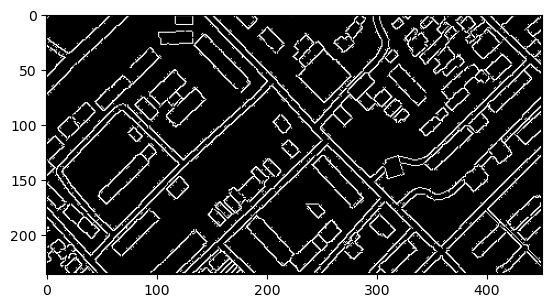

In [16]:
hst = hysteresis(dt, weak, strong)
plt.imshow(hst.astype('int'), cmap='gray')

<h4>Switching to matplotlib</h4>

In [104]:
X = list()
Y = list()
for i in range(len(hst)):
    for j in range(len(hst[i])):
        if hst[i][j] == 255:
            X.append(i)
            Y.append(j)
X = np.array(X)
Y = np.array(Y)

In [105]:
len_ = np.sqrt(X.max()**2 + Y.max()**2)
X=np.array(X)/len_
Y=np.array(Y)/len_
X = X[::-1]

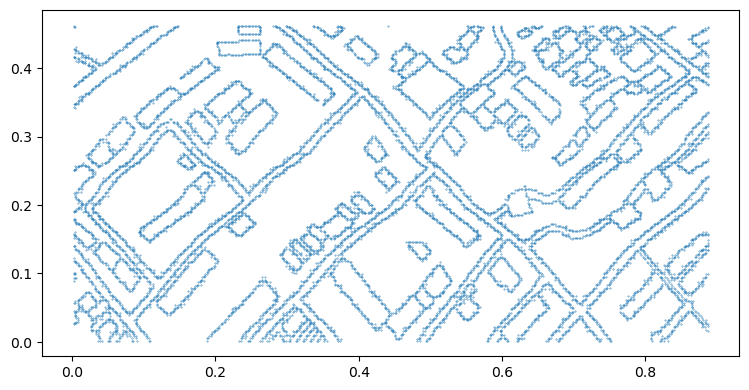

In [106]:
plt.figure(figsize=(9, 4.5))
plt.scatter(Y, X, s = 0.1)

<h4>Quadtree</h4>

In [111]:
points = []
quads = [[[0, X.max()], [0, Y.max()]]]

In [115]:
X

array([0.00197505, 0.11257767, 0.11455272, ..., 0.80976922, 0.81964446,
       0.8216195 ])

In [116]:
Y

array([0.46216097, 0.46216097, 0.46216097, ..., 0.00197505, 0.00197505,
       0.00197505])

In [112]:
coor = np.stack((X, Y)).T
coor.shape
coor

array([[0.00197505, 0.46216097],
       [0.11257767, 0.46216097],
       [0.11455272, 0.46216097],
       ...,
       [0.80976922, 0.00197505],
       [0.81964446, 0.00197505],
       [0.8216195 , 0.00197505]])

In [119]:
def check(quad, coor):
    for j in range(len(coor)):
        if((quad[0][0] < coor[j][0] < quad[0][1]) and (quad[1][0] < coor[j][1] < quad[1][1])):
            return False 
    return True
                

In [120]:
while (len(points)<1000):
    for i in range(len(quads)):
        if check(quads[i], coor):
            points.append([quads[i][0][0], quads[i][1][0]])
            points.append([quads[i][0][1], quads[i][1][1]])                
            points.append([quads[i][0][0], quads[i][1][1]])                
            points.append([quads[i][0][1], quads[i][1][0]])  
        else:
            quads.append([[quads[i][0][0], quads[i][0][1]/2], [quads[i][1][0], quads[i][1][1]/2]])
            quads.append([[quads[i][0][1]/2, quads[i][0][1]], [quads[i][1][1]/2, quads[i][1][1]]])        
            quads.append([[quads[i][0][0], quads[i][0][1]/2], [quads[i][1][1]/2, quads[i][1][1]]])        
            quads.append([[quads[i][0][1]/2, quads[i][0][1]], [quads[i][1][0], quads[i][1][1]/2]])
        quads.remove(quads[i])

In [90]:
points

[[0, 0.4433980257012541],
 [0.11554024277738692, 0.4433980257012541],
 [0, 0.4433980257012541],
 [0.11554024277738692, 0.4433980257012541],
 [0, 0.22169901285062704],
 [0.05777012138869346, 0.22169901285062704],
 [0, 0.22169901285062704],
 [0.05777012138869346, 0.22169901285062704],
 [0.23108048555477384, 0.4433980257012541],
 [0.23108048555477384, 0.4433980257012541],
 [0.23108048555477384, 0.4433980257012541],
 [0.23108048555477384, 0.4433980257012541],
 [0.23108048555477384, 0.4433980257012541],
 [0.23108048555477384, 0.8867960514025082],
 [0.23108048555477384, 0.8867960514025082],
 [0.23108048555477384, 0.4433980257012541],
 [0.11554024277738692, 0.22169901285062704],
 [0.11554024277738692, 0.22169901285062704],
 [0.11554024277738692, 0.22169901285062704],
 [0.11554024277738692, 0.22169901285062704],
 [0.11554024277738692, 0.22169901285062704],
 [0.11554024277738692, 0.4433980257012541],
 [0.11554024277738692, 0.4433980257012541],
 [0.11554024277738692, 0.22169901285062704],
 [0, 0

In [121]:
points = np.array(points)

In [122]:
points[:, :1]

array([[0.        ],
       [0.22169901],
       [0.        ],
       ...,
       [0.44339803],
       [0.44339803],
       [0.44339803]])

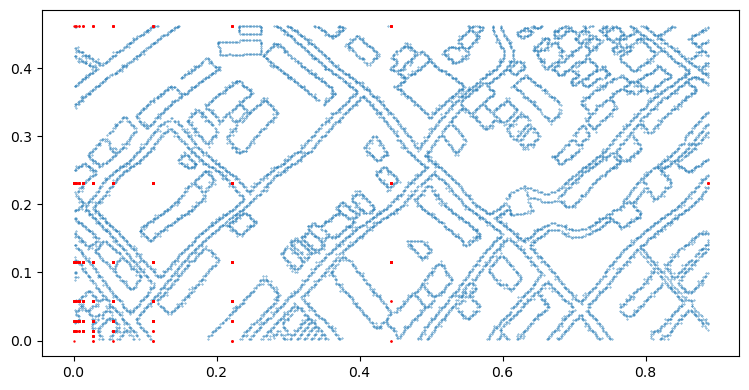

In [123]:
plt.figure(figsize=(9, 4.5))
plt.scatter(X, Y, s = 0.1)
plt.scatter(points[:, 0:1], points[:, 1:2], s = 0.5, c='red')

<h4>Quadtree1</h4>

In [124]:
points = []
quads_old = [[[0, X.max()], [0, Y.max()]]]
quads_new = []

In [125]:
coor = np.stack((X, Y)).T
coor.shape
coor

array([[0.00197505, 0.46216097],
       [0.11257767, 0.46216097],
       [0.11455272, 0.46216097],
       ...,
       [0.80976922, 0.00197505],
       [0.81964446, 0.00197505],
       [0.8216195 , 0.00197505]])

In [126]:
def check(quad, coor):
    for i in range(len(coor)):
            if ((quad[0][0] < coor[i][0] < quad[0][1]) and (quad[1][0] < coor[i][1] < quad[1][1])):
                return False 
    return True

In [127]:
while(len(points)<1000):
# for j in range(2):
    for i in range(len(quads_old)):
        if (check(quads_old[i], coor)): 
            points.append([quads_old[i][0][0], quads_old[i][1][0]])    
            points.append([quads_old[i][0][1], quads_old[i][1][1]]) 
            points.append([quads_old[i][0][1], quads_old[i][1][0]]) 
            points.append([quads_old[i][0][0], quads_old[i][1][1]]) 
        else: 
            quads_new.append([[quads_old[i][0][0], quads_old[i][0][1]/2], [quads_old[i][1][0], quads_old[i][1][1]/2]])
            quads_new.append([[quads_old[i][0][1]/2, quads_old[i][0][1]], [quads_old[i][1][1]/2, quads_old[i][1][1]]])  
            quads_new.append([[quads_old[i][0][0], quads_old[i][0][1]/2], [quads_old[i][1][1]/2, quads_old[i][1][1]]])
            quads_new.append([[quads_old[i][0][1]/2, quads_old[i][0][1]], [quads_old[i][1][0], quads_old[i][1][1]/2]])  
    quads_old = quads_new 
    quads_new = []

In [128]:
points = np.array(points)

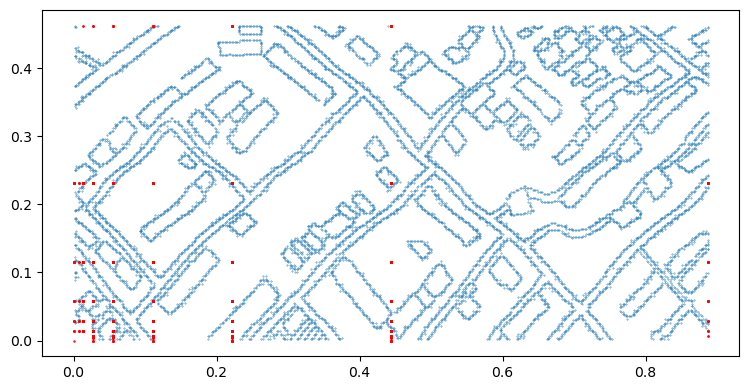

In [130]:
plt.figure(figsize=(9, 4.5))
plt.scatter(X, Y, s = 0.1)
plt.scatter(points[:, 0:1], points[:, 1:2], s = 0.5, c='red')

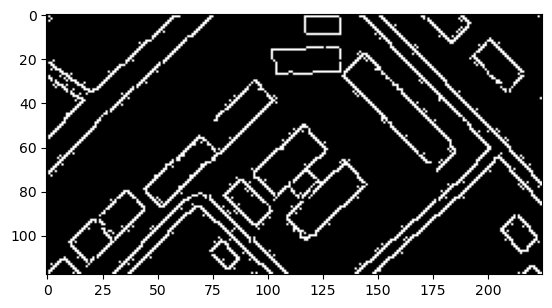

In [132]:
plt.imshow(hst[:118, :225].astype('int'), cmap='gray')

In [131]:
hst.shape

(236, 451)

In [133]:
255 in hst[:118, :225]

True

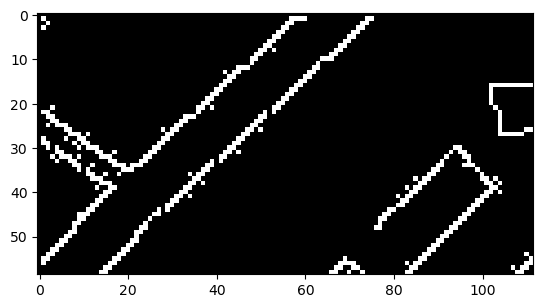

In [134]:
plt.imshow(hst[:59, :112].astype('int'), cmap='gray')

In [135]:
255 in hst[:59, :112]

True

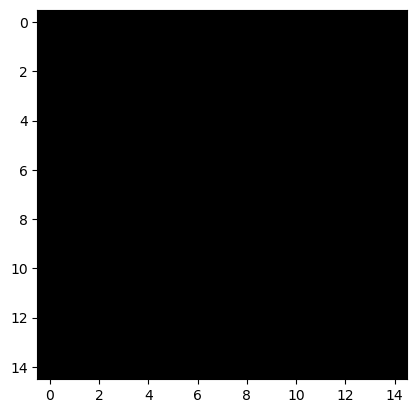

In [137]:
plt.imshow(hst[10:25, 10:25].astype('int'), cmap='gray')

In [138]:
255 in hst[10:25, 10:25]

False